# Lidar pointcloud analysis using laserchicken

In this tutorial, we demonstrate an example of analysing AHN3 pointcloud data using the `laserchicken` package.

### The dataset

AHN (Actueel Hoogtebestand Nederland) is a digtal height dataset of the Netherlands, measured with laser altimetry. The [AHN3](https://www.pdok.nl/introductie/-/article/actueel-hoogtebestand-nederland-ahn3-) dataset, which is used in this tutorial, is the third update of this dataset. 

AHN3 is a public dataset and is free from copyright restrictions. Please refer to [this link](https://data.overheid.nl/en/dataset/11513-actueel-hoogtebestand-nederland-3--ahn3-) for the license status of AHN3.

In [1]:
import numpy as np
import laserchicken as lc
from matplotlib import pyplot as plt

To avoid the code duplication, we will write a small function `visualize_pc` to visualize the pointcloud later.

In [2]:
def visualize_pc(pc, col, npmax=None, clabel=None, pointsize=3):
    """
    pc: input pointcloud
    col: data column to be visualized
    npmax: max number of points to visualize
    clable: colorbar lable
    pointsize: visualized point size 
    """
    fig, ax = plt.subplots()
    npoints = pc['vertex']['x']['data'].shape[0]
    x, y, data = lc.utils.get_features(pc, ['x', 'y', col])
    if npmax is not None:
        if npoints>npmax: # vilsualize up to npmax points
            idx=np.random.choice(range(npoints),npmax)
            x = x[idx]
            y = y[idx]
            data = data[idx]
    sc = ax.scatter(x, y, c = data, s = pointsize)
    ax.grid()
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('RD x [m]')
    ax.set_ylabel('RD y [m]')
    fig.colorbar(sc, label=clabel)
    plt.show()

### Step 1: Data loading

After the preparation job, we can start the data analysis with laserchicken. 

First we will use the `load` function to load in the raw pointcloud data stored in `AHN.las`. Note that apart from `.las`, the `load` function also support `.laz` and `.ply` format. 

In [3]:
# from laserchicken import load
pc = lc.load('../data/AHN3.las')
z, = lc.utils.get_features(pc, ['z'])
print("Loaded features: {}".format(pc['vertex'].keys()))
print("Total number of points: {}".format(z.shape[0]))


Loaded features: dict_keys(['x', 'y', 'z', 'gps_time', 'raw_classification', 'intensity'])
Total number of points: 394473


One can also choose to only load the selected features. E.g., only load the coordinates of the points:

In [4]:
pc_simple = lc.load('../data/AHN3.las', attributes = ['x', 'y', 'z'])
z, = lc.utils.get_features(pc_simple, ['z'])
print("Loaded features: {}".format(pc_simple['vertex'].keys()))
print("Total number of points: {}".format(z.shape[0]))

Loaded features: dict_keys(['x', 'y', 'z'])
Total number of points: 394473


To get a general overview of the point cloud, we can visualize the height for point of the points. Since 394473 is really a huge number of point, we will visualize 20000 points of the entire number.

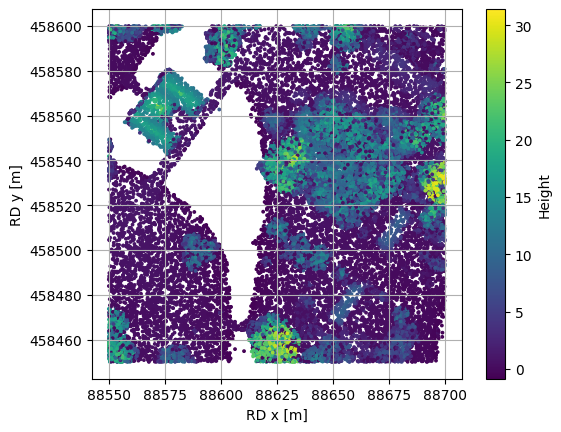

In [5]:
visualize_pc(pc, col='z', clabel='Height', npmax = 40000) # only visualize 40000 points

### Step 2: height normalization

Since AHN3 uses a absolute height reference system. However, in our case, we are more interested in the height of the points relative to the local ground. Therefore a height normalization process is applied to remove the topography from the height. We can use the `normalize` function to do this.

Height range: -0.89 - 32.013, mean: 7.429283157529158
Normalized height range: 0.0 - 32.903, mean: 8.319283157529162


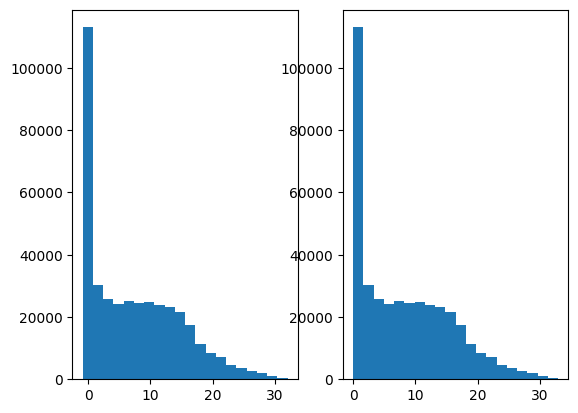

In [17]:
from laserchicken.normalize import normalize
pc = normalize(pc)

# Investigate the height vs normalized height
height, height_norm = lc.utils.get_features(pc, ['z', 'normalized_height'])
print("Height range: {} - {}, mean: {}".format(height.min(), height.max(), height.mean()))
print("Normalized height range: {} - {}, mean: {}".format(height_norm.min(), height_norm.max(), height_norm.mean()))
plt.subplot(1,2,1)
plt.hist(height, bins=20)
plt.subplot(1,2,2)
plt.hist(height_norm, bins=20)
plt.show()

If no extra argument is specified, the `normalize` function uses the miminum height in the point cloud as a reference height, and re-refence all points to this height. This can be told from the range change and mean change we just printed out: the mean height change equals the miminum original height. Besides, the normalized height historgram only shifted to right comparing to the original height histogram, but there is no distribution change.

The `normalize` height also supports local height normalization. This can be done by specifying the `cell_size` argument. If `cell_size` is given, a temporary grid of `cell_size` x `cell_size` (in meters) will be spanned over the full point cloud area. All points will be referenced to the minimum height within each cell. 

Cylinder size in Bytes: 144199102.79977155
Memory size in Bytes: 8227647488
Start tree creation
Done with env tree creation
Done with target tree creation
Height range: -0.89 - 32.013, mean: 7.429283157529158
Normalized height range: 0.0 - 31.665999999999997, mean: 7.069156461912477


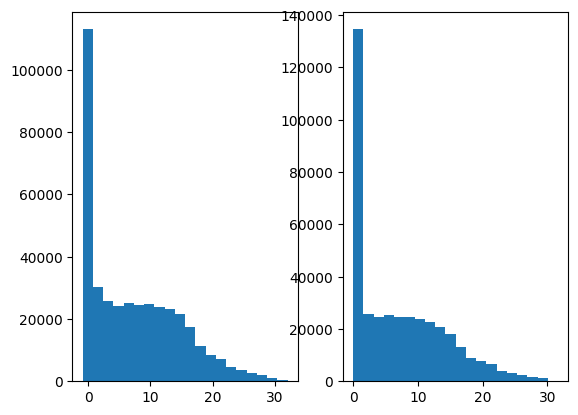

In [19]:
# Height normalization within each 5x5m grid cell 
pc = normalize(pc, cell_size=5)

# Investigate the height vs normalized height
height, height_norm = lc.utils.get_features(pc, ['z', 'normalized_height'])
print("Height range: {} - {}, mean: {}".format(height.min(), height.max(), height.mean()))
print("Normalized height range: {} - {}, mean: {}".format(height_norm.min(), height_norm.max(), height_norm.mean()))
plt.subplot(1,2,1)
plt.hist(height, bins=20)
plt.subplot(1,2,2)
plt.hist(height_norm, bins=20)
plt.show()

As we can see, when normalizing within each grid cell, the distribution of the normalized height also changed, instead of a single shift. We can also visualized the normalized height:

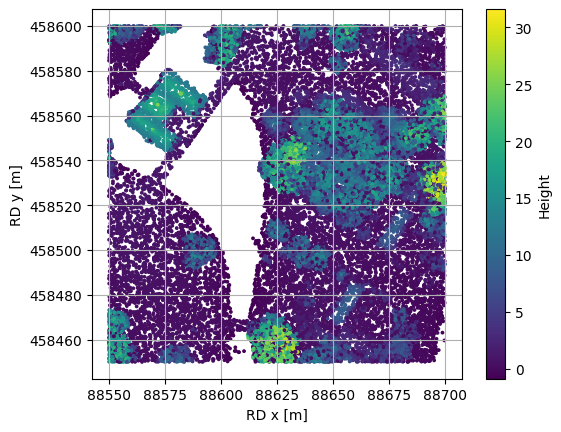

In [20]:
visualize_pc(pc, col='z', clabel='Height', npmax = 40000)

A new attribute `normalized_height` will be added to the point cloud. We can compare the height range before and after normalization:

In [23]:
height, = lc.utils.get_features(pc, ['z'])
height_norm, = lc.utils.get_features(pc, ['normalized_height'])
print("Height range: {} - {}".format(height.min(), height.max()))
print("Normalized height range: {} - {}".format(height_norm.min(), height_norm.max()))

Height range: -0.89 - 32.013
Normalized height range: 0.0 - 32.903


### Step 3: data filtering

Data filtering may be applied to zoom into a certain subset of the point cloud we are interested in. In `laserchicken`, it's possible to fileter the point cloud spatially, or based on value range of a certain attribute.

To apply spatial filter on the data, one can use the `select_polygon` function with a predefined polygon:

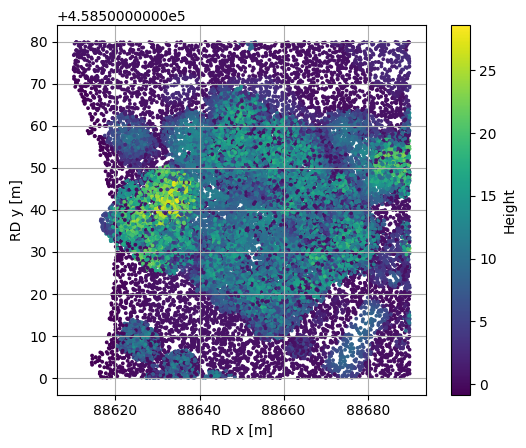

In [24]:
from laserchicken.filter import select_polygon
from shapely.geometry import Polygon

# Define a croping
west = 88610
east = 88690
south = 458500
north = 458580
polygon = Polygon.from_bounds(east, south, west, north)

pc_crop = select_polygon(pc, polygon.wkt)
visualize_pc(pc_crop, col='z', clabel='Height', npmax=40000)

To filter data based on attribute value, there are three selection functions: `select_above`, `select_below` and `select_equal`. For example, we know the height reference point has normalized_height=0, we can find that point by `select_equal`:

In [25]:
from laserchicken.filter import select_equal

# Select height reference point, which has the 'normalized_height' equal to zero
p_ref = select_equal(pc, 'normalized_height', 0)
xref, yref, zref = lc.utils.get_features(p_ref, ['x', 'y', 'normalized_height'])
print("Coordinates (x, y, norm_height) of the reference points: ({}, {}, {})".format(xref[0], yref[0], zref[0]))

Coordinates (x, y, norm_height) of the reference points: (88587.141, 458594.375, 0.0)


We can use `select_above` and `select_below` to separate the groud point and the non ground points.

In [26]:
from laserchicken.filter import select_above, select_below

# Assume all points with normalized height below the threshold should be ground points.
height_thres = 0.5 

# Filtering
pc_ground = select_below(pc, 'normalized_height', height_thres)
pc_non_ground = select_above(pc, 'normalized_height', height_thres)

# Inspection
nh_ground, = lc.utils.get_features(pc_ground, ['normalized_height'])
nh_non_ground, = lc.utils.get_features(pc_non_ground, ['normalized_height'])
print("Groud points norm-height range: {} - {}".format(nh_ground.min(), nh_ground.max()))
print("Non groud points norm-height range: {} - {}".format(nh_non_ground.min(), nh_non_ground.max()))


Groud points norm-height range: 0.0 - 0.499
Non groud points norm-height range: 0.501 - 32.903


In later processing we will use `pc_non_ground`.

### Step 4: feature extraction

For a better understading of the poincloud, we need to investigate the common characters of multiple points within a certain range. 

To do this, we devide the poincloud into volumes. Within each volume, various statistics are computed to represent the volume. These statistics are referred as "features". In each volume, the derived features are assigned to an artificial point representing the volume, which is referred as the "target point".  

We can first check what are the build-in features in `laserchicken`: 

In [27]:
from laserchicken.feature_extractor.feature_extraction import list_feature_names
sorted(list_feature_names())

['band_ratio_10<normalized_height',
 'band_ratio_1<normalized_height<2',
 'band_ratio_2<normalized_height<3',
 'band_ratio_3<normalized_height',
 'band_ratio_normalized_height<1',
 'coeff_var_intensity',
 'coeff_var_normalized_height',
 'coeff_var_z',
 'density_absolute_mean_normalized_height',
 'density_absolute_mean_z',
 'echo_ratio',
 'eigenv_1',
 'eigenv_2',
 'eigenv_3',
 'entropy_normalized_height',
 'entropy_z',
 'kurto_normalized_height',
 'kurto_z',
 'max_intensity',
 'max_normalized_height',
 'max_z',
 'mean_intensity',
 'mean_normalized_height',
 'mean_z',
 'median_normalized_height',
 'median_z',
 'min_intensity',
 'min_normalized_height',
 'min_z',
 'normal_vector_1',
 'normal_vector_2',
 'normal_vector_3',
 'perc_100_normalized_height',
 'perc_100_z',
 'perc_10_normalized_height',
 'perc_10_z',
 'perc_11_normalized_height',
 'perc_11_z',
 'perc_12_normalized_height',
 'perc_12_z',
 'perc_13_normalized_height',
 'perc_13_z',
 'perc_14_normalized_height',
 'perc_14_z',
 'per

One option to create target points is to define the a homogeneous grid, and create one target point within each grid. 

Here we first define the grid, then use `laserchicken.utils.create_point_cloud` to create target points with given coordinates.

In [28]:
# Resolution of the target pointcloud, in meter
resolution = 2

# Define the grid system 
pcx, pcy = lc.utils.get_features(pc_non_ground, ['x', 'y'])
x = np.arange(pcx.min(), pcx.max(), resolution) + resolution/2.
y = np.arange(pcy.min(), pcy.max(), resolution) + resolution/2.
xv, yv = np.meshgrid(x, y)

# Create target points:
targets = lc.utils.create_point_cloud(x = xv.flatten(),
                            y = yv.flatten(),
                            z = np.zeros_like(xv.flatten()))
targets

{'vertex': {'x': {'type': 'float64',
   'data': array([88551., 88553., 88555., ..., 88695., 88697., 88699.])},
  'y': {'type': 'float64',
   'data': array([458451., 458451., 458451., ..., 458599., 458599., 458599.])},
  'z': {'type': 'float64', 'data': array([0., 0., 0., ..., 0., 0., 0.])}},
 'pointcloud': {},
 'log': []}

After the target pointcloud is made, the statistics will be aggregated to the target point. The aggregation per target point is performed with a given searching volume, which has a customizable shape and size. Here we use the "cell" volume with the size of target pointcloud resolution. 


In [29]:
from laserchicken import build_volume

volume = build_volume("cell", side_length=resolution)
volume

Per target point, we first find the neighboring points from the orihinal point cloud within the given aggragation volum. Then we compute the statistics of interest. Here we compute the "mean normalized height", which will be added as a feature to the target pointcloud.

Cylinder size in Bytes: 144199102.79977155
Memory size in Bytes: 8227647488
Start tree creation
Done with env tree creation
Done with target tree creation
Extracting feature(s) "['mean_normalized_height', 'std_normalized_height', 'coeff_var_normalized_height']"Extracting feature(s) "['mean_normalized_height', 'std_normalized_height', 'coeff_var_normalized_height']" took 0.15 seconds
The following unrequested features were calculated as a side effect, but will not be returned: ['coeff_var_normalized_height', 'std_normalized_height']


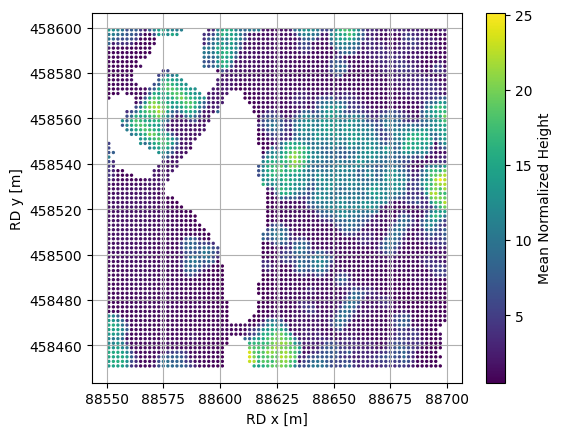

In [30]:
from laserchicken import compute_neighborhoods, compute_features

neighborhoods = compute_neighborhoods(pc_non_ground, targets, volume)
compute_features(pc_non_ground, neighborhoods, targets, ['mean_normalized_height'], volume)
visualize_pc(targets, col='mean_normalized_height', clabel='Mean Normalized Height', pointsize=2)

`laserchicken` also supports self defined feature extractor. Below is an example of a self-defined feature extractor which computes the ratio of points within the volumn with height >10m.

Cylinder size in Bytes: 144199102.79977155
Memory size in Bytes: 8227647488
Start tree creation
Done with env tree creation
Done with target tree creation
Extracting feature(s) "['band_ratio_10<normalized_height']"Extracting feature(s) "['band_ratio_10<normalized_height']" took 0.06 seconds


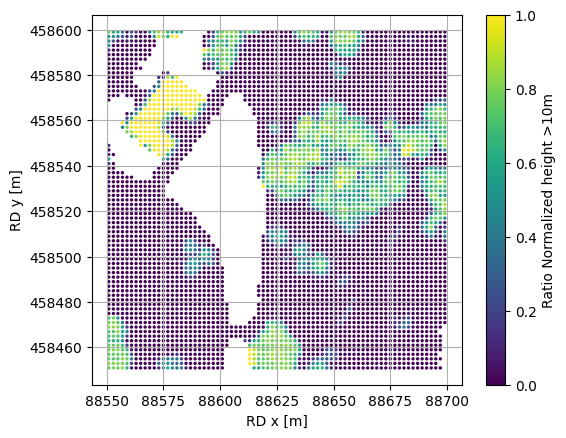

In [31]:
from laserchicken import register_new_feature_extractor
from laserchicken.feature_extractor.band_ratio_feature_extractor import BandRatioFeatureExtractor
register_new_feature_extractor(BandRatioFeatureExtractor(10,None,data_key='normalized_height'))

volume = build_volume("cell", side_length=resolution)
neighborhoods = compute_neighborhoods(pc_non_ground, targets, volume)
compute_features(pc_non_ground, neighborhoods, targets, ['band_ratio_10<normalized_height'], volume)
visualize_pc(targets, col='band_ratio_10<normalized_height', clabel='Ratio Normalized height >10m', pointsize=2)

The results can be exported to the disk.

In [32]:
from laserchicken import export
export(targets, 'my_output.laz')